# Of Kernels and Queues: when network calculus meets analytics combinatorics

This notebook provides the companion code for <a href="https://doi.org/10.1109/ITC30.2018.10061">the eponym article</a>. Please refer to the main article for all details.

# Settings

In [1]:
import numpy as np
from numba import njit, jit

from scipy import optimize
from scipy.misc import derivative
from scipy.special import binom

import matplotlib.pyplot as plt

import pandas as pd

np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Distributions

The paper is evaluated on bimodal distributions

In [2]:
def bimodal(λ, Amax):
    """
    Returns an array that represents a bimodal distribution (p_0 / P_Amax), with arrival rate λ
    """
    A = np.zeros(Amax+1)
    A[Amax] = λ / Amax
    A[0] = 1 - λ / Amax
    return A

A binomial distribution could be used as well.

In [3]:
def binomiale(p, n):
    """
    returns an array that represents a binomial distribution (p , n), with arrival rate λ = np
    """
    A = np.zeros(n+1)
    for i in range(n+1):
        A[i] = binom(n,i) * p**i * (1-p)**(n-i)
    return A

# Auxiliary functions

Save results to CSV

In [4]:
def save_data(filename, R, doobs, noyau, simu):
    csv = pd.DataFrame({'R': R, 'doobs': doobs, 'noyau': noyau, 'simu': simu})
    csv.to_csv(filename+".csv", index=False)    

Jitted 2D-convolution that allows to consider two joint arrivals in two queues. Slower than FFT for full convolutions, but the distributions in the paper are sparse so a jitted approach is interesting.

In [5]:
@njit()
def my_conv2d(XY, AB):
    m, n = XY.shape
    k, l = AB.shape
    NXY = np.zeros((m+k-1, n+l-1))
    for i in range(k):
        for j in range(l):
            if AB[i, j] != 0:
                NXY[i:(m+i), j:(n+j)] += XY * AB[i, j]
    return NXY

Generating function associated with an arrival distribution $A$, derivative of the generating function, expected value of the arrival.

In [6]:
def gen(A):
    n = np.arange(len(A))
    return lambda x: np.sum(A * (x**n))

def dev(A):
    n = np.arange(1,len(A))
    return lambda x: np.sum(n * A[1:] * (x**(n-1)))

# To find back λ
def E(A):
    return sum(A * np.arange(len(A)))

A simple golden search implementation to find minimal value between $a$ and $b$ for a unimodal function. Loosely adapted from https://en.wikipedia.org/wiki/Golden-section_search.

In [7]:
invphi = (np.math.sqrt(5) - 1) / 2 # 1/phi
invphi2 = (3 - np.math.sqrt(5)) / 2 # 1/phi^2

def gss(f,a,b):
    (a,b)=(min(a,b),max(a,b))
    h = b - a

    c = a + invphi2 * h
    d = a + invphi * h
    yc = f(c)
    yd = f(d)
    ϵ = 1
    i=1000
    while ϵ>0:
        if yc < yd:
            b = d
            d = c
            yd = yc
            h = invphi * h
            c = a + invphi2 * h
            yc = f(c)
            ϵ = d - a
        else:
            a = c
            c = d
            yc = yd
            h = invphi * h
            d = a + invphi * h
            yd = f(d)
            ϵ = b - c
        i -= 1
        if i == 0:
            break
    if yc < yd:
        return a
    else:
        return c

A simple dichotomy implementation to find the root of an increasing function.

In [8]:
def dicho(f, a, b):
    ϵ = 1
    i = 10000
    while ϵ > 0:
        c = (a+b) / 2
        if f(c) > 0:
            b = c
        else:
            a = c
        ϵ /= 2
        i -= 1
        if i == 0:
            break
    return c

Find the right root of a unimodal function $f(x)-x$ which has a negative minimum value, knowing that the left root is smaller than or equal to 1 (cf Figure 1 in the article).
- Find a value $M>1$ for which the function is positive
- Use a golden search to locate the minimum $x$
- The function is increasing in $[m, M]$, so a dichotomy finds the root

In [9]:
def second_root(f):
    '''Finds the second solution of x=f(x), which is assumed to be greater than 1'''
    g = lambda z: f(z) - z
    M = 2.0
    while g(M) <= 0:
        M *= 2
    m = gss(g, 1, M)
    return dicho(g, m, M)

Build Complementary Cumulative Distribution Function.

In [10]:
def make_CCDF(x):
    y = 1 - np.cumsum(x)
    y = np.roll(y, 1)
    y[0] = 1
    return y

Display and save results in the way used in the article, where the kernel method can always express the asymptotic behavior as CCDF as $P(X\geq R)\approx K\beta^{-R}$.

In [11]:
def plot_kernel(β, K, simu, description, xm=20, ym=1e-4):
    xmax = len(simu)
    R = np.arange(xmax)
    doobs = β**(-R)
    kernel = K * doobs
    doobs *= β
    plt.xlim([0, xm])
    plt.ylim([ym, 1])
    plt.semilogy(R, doobs, label="$\\beta^{-R}$")
    plt.semilogy(R, kernel, label='Kernel')
    plt.semilogy(R, simu[:xmax], label='Simulation')
    save_data(description, R, doobs, kernel, simu)
    plt.legend()
    plt.show()

# Single Server Queue

## Simulation

We remind that the system is considered in a slotted manner. Each slot is placed just after packets have arrived and before the server(s) process(es) any packet. Thus, to deduce one slot from the other, one needs to first serve packets, then make new arrivals.

The simulation will compute the evolution of the probability distribution, starting from an initial state where queue is empty, until a convergence criterium is met.

In [12]:
@njit()
def simu_simple(A, Xmax=200, ϵ=10**(-12)):
    """
    Fixed-point computation of the system distribution.
    - Pop one paquet (shift X)
    - Add new packets using convolution with A
    - Packets above Xmax are dropped
    """
    old_X = np.zeros(Xmax+1)
    X = np.zeros(Xmax+1)
    X[0] = 1
    while (np.sum(np.abs(old_X-X))) > ϵ:
        old_X = X.copy()
        # We serve a packet
        X[0:-1] = X[1:]
        X[-1] = 0
        X[0] += 1 - np.sum(X)
        # New packets arrive
        X = np.convolve(X, A)[0:(Xmax+1)]
        X[-1] += 1 - np.sum(X)    
    return X

## Numerical evaluation of the Kernel method

The paper gives the formula

$$P(X_t \geq R) \sim (1-E[A])\frac{\beta}{A'(\beta)-1} \beta^{-R},$$

where $\beta$ is the second solution of $x = A(x)$

In [13]:
def kernel_simple(A):
    β = second_root(gen(A))
    K = (1-E(A)) * β / (dev(A)(β)-1)
    return β, K

## Display

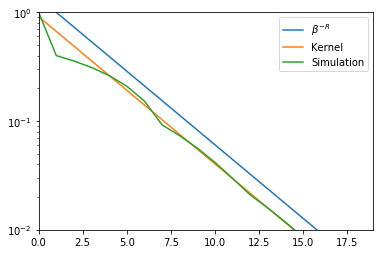

In [14]:
λ = .4
burst = 6
A = bimodal(λ, burst)
β, K = kernel_simple(A)
simu = make_CCDF(simu_simple(A, 200))
description = "single_server_λ_%s_bimodal_%s" % (λ, burst)
plot_kernel(β, K, simu, description, xm=19, ym=1e-2)

# Two flows with priority

## Simulation

We are still just after packets arrive and before they are served.

As we have two dependent flows, we store their distribution in a matrix $XY$. $XY[i,j]$ is the probability to be in state $(i, j)$.

The update is made as follows:
- We serve one $Y$ for the states where $X$ is empty (cf. paper):
 - ``T0=XY[0,0]`` (remind full empty probability)
 - ``XY[0, 0:-1] = X[0,1:]`` (shift $Y$ by one)
 - ``X[0,0]+=T0`` (update full empty probability)
 - ``X[0,-1]=0`` (clean right side of the shift)
- We serve one $X$:
 - ``TX = X[0,:].copy()`` (remind when $X$ is empty)
 - ``X[0:-1,:] = X[1:,:]`` (shift $X$ by one)
 - ``X[0,:]+=TX`` (update $X$ empty)
 - ``X[-1,:]=0`` (right side of the shift)
- Use 2D convolution for packet arrivals.

In [15]:
@njit()
def simu_two_flows(A, B, Xmax=200, ϵ=10**(-9)):
    """
    Fixed-point computation of the stationary distribution.
    - Pop one Y if X empty: T0=XY[0,0], XY[0, 0:-1] = X[0,1:], X[0,0]+=T0, X[0,-1]=0,
    - Pop one X : TX = X[0,:], X[0:-1,:] = X[1:,:], X[0,:]+=TX, X[-1,:]=0
    - Use convolution to for packet injection.
    - Trim and normalize to avoid drifts
    """
    AB = np.dot(A.reshape((len(A),1)), B.reshape((1,len(B))))
    old_XY = np.zeros((Xmax, Xmax))
    XY = np.zeros((Xmax, Xmax))
    XY[0,0] = 1
    while (np.sum(np.abs(old_XY-XY))) > ϵ:
        old_XY = XY.copy()
        # Pop one Y if X is empty
        T0 = XY[0, 0]
        XY[0, 0:-1] = XY[0, 1:]
        XY[0, -1] = 0
        XY[0,0] += T0
        # Pop one X
        T1 = XY[0,:].copy()
        XY[0:-1, :] = XY[1:, :]
        XY[0,:] += T1
        XY[-1,:] = 0
        # New arrivals
        XY = my_conv2d(XY, AB)
        # Drop packets above X capacity
        XY[Xmax-1, :] += np.sum(XY[Xmax:, :], axis=0)
        # Drop packets above Y capacity
        XY[:, Xmax-1] += np.sum(XY[:, Xmax:], axis=1)
        # Trim
        XY = XY[:Xmax, :Xmax]
        # Report drift errors on empty state
        XY[0, 0] += 1 - np.sum(XY)
    # Project on Y to give result (X is unaware of Y and can be computed using first formula)
    return np.sum(XY, axis=0)

## Kernel

For the two flows, we need to solve:


$$P(Y_t\geq R) \sim \frac{ B(\gamma)(\gamma-1)(1-E[A + B])}{(1-B(\gamma))  (1-B'(\gamma)T'_A(B(\gamma)))} \gamma^{-R}.$$

 $T_A(x)$ associates with $x$ the solution of $y = xA(y)$

 
 $\gamma$ is the largest solution of $v=T_A(B(v))$

In [16]:
def TA(A):
    def f(x):
        y = 0
        i = 500
        yn = x * gen(A)(y)
        while y != yn:
            y = yn
            yn = x * gen(A)(y)
            i -= 1
            # We don't need accuracy for large value.
            # The trick below avoids throwing error when we are above the convergence radius.
            if (i == 0) or (yn-x >= 2):
                return 2 + (x+1)**2
        return yn
    return f
            

def γAB(A, B):
    return second_root(lambda x: TA(A)(gen(B)(x)))

def kernel_two_flows(A, B):
    γ = γAB(A, B)
    Tprime = derivative(lambda x: TA(A)(x), gen(B)(γ), dx = 1e-6)
    K = gen(B)(γ) * (γ-1) * (1-E(A)-E(B)) / (1-gen(B)(γ)) / (1-dev(B)(γ)*Tprime)
    return γ, K  

## Display

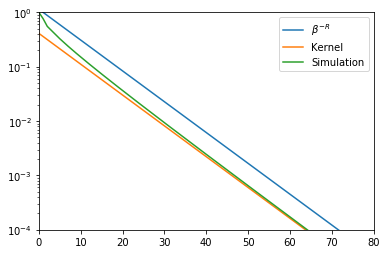

In [17]:
λA = .4
bA = 6
λB = .4
bB = 1
A = bimodal(λA, bA)
B = bimodal(λB, bB)
β, K = kernel_two_flows(A, B)
simu = make_CCDF(simu_two_flows(A, B))
description = "two_flows_λA_%s_bA_%s_λB_%s_bB_%s" % (λA, bA, λB, bB)
plot_kernel(β, K, simu, description, xm = 80, ym=1e-4)

# Two queues

## Simulation

As we have two dependent queues, we store their distribution in a matrix $XY$. $XY[i,j]$ is the probability to be in state $(i, j)$.

The update is made as follows:
- We serve one $Y$ for the states where $X$ is empty (cf paper):
 - ``T0 = XY[0,0]`` (remind full empty probability)
 - ``XY[0, 0:-1] = X[0,1:]`` (shift $Y$ by one)
 - ``X[0,0] += T0`` (update full empty probability)
 - ``X[0,-1] = 0`` (clean right side of the shift)
- We serve one $Y$ for the states where $X$ is not empty and inject add one $X$ packet to $Y$:
 - ``X[1:, 1] += X[1:, 0]`` (1-1=0, so the only change is that if Y was empty, it now has one packet)
 - ``X[1:, 0] = 0`` (if $X$ is not empty, $Y$ cannot be empty)
- We serve one $X$:
 - ``TX = X[0,:].copy()`` (remind when $X$ is empty)
 - ``X[0:-1,:] = X[1:,:]`` (shift $X$ by one)
 - ``X[0,:] += TX`` (update $X$ empty)
 - ``X[-1,:] = 0`` (right side of the shift)
- Use 2D convolution for packet arrivals.

In [18]:
@njit()
def simu_two_queues(A, B, Xmax=200, ϵ=10**(-9)):
    """
    Fixed-point computation of the stationary distribution.
    - Pop one Y if X empty: T0=XY[0,0], XY[0, 0:-1] = X[0,1:], X[0,0]+=T0, X[0,-1]=0,
    - if X not empty, the pop Y is compensated by the push X
      except if Y was empty in case one packet is added: X[1:,1] += X[1:,0], X[1:,0]=0
    - Pop one X : TX = X[0,:], X[0:-1,:] = X[1:,:], X[0,:]+=TX, X[-1,:]=0
    - Use convolution to for packet injection.
    - Trim and normalize to avoid drifts
    """
    AB = np.dot(A.reshape((len(A),1)), B.reshape((1,len(B))))
    old_XY = np.zeros((Xmax, Xmax))
    XY = np.zeros((Xmax, Xmax))
    XY[0,0] = 1
    while (np.sum(np.abs(old_XY-XY))) > ϵ:
        old_XY = XY.copy()
        # Pop Y when X is empty
        T0 = XY[0, 0]
        XY[0, 0:-1] = XY[0, 1:]
        XY[0, -1] = 0
        XY[0,0] += T0
        # Pop/push Y when X is not empty
        XY[1:, 1] += XY[1:, 0]
        XY[1:, 0] = 0
        # Pop X
        T1 = XY[0,:].copy()
        XY[0:-1, :] = XY[1:, :]
        XY[0,:] += T1
        XY[-1,:] = 0
        # New arrivals
        XY = my_conv2d(XY, AB)
        # Drop extra packets
        XY[Xmax-1, :] += np.sum(XY[Xmax:, :], axis=0)
        XY[:, Xmax-1] += np.sum(XY[:, Xmax:], axis=1)
        # Trim
        XY = XY[:Xmax, :Xmax]
        # Normalize
        XY[0, 0] += 1 - np.sum(XY)
    # Projection on Y
    return np.sum(XY, axis=0)

## Kernel

For two queues, we need to solve:

 $$P(Y_t\geq R) \sim \frac{ \gamma(\gamma-1)(1-E[A + B])}{(1-B(\gamma))  (1-B'(\gamma)T'_A(B(\gamma))} \gamma^{-R}.$$

 $T_A(x)$ associates with $x$ the solution of $y = xA(y)$

 $\gamma$ is the largest solution of $v=T_A(B(v))$

In [19]:
def kernel_two_queues(A, B):
    γ = γAB(A, B)
    Tprime = derivative(lambda x: TA(A)(x), gen(B)(γ), dx=1e-6)
    K = γ * (γ-1) * (1-E(A)-E(B)) / (1-gen(B)(γ)) / (1-dev(B)(γ)*Tprime)
    return γ, K

## Display

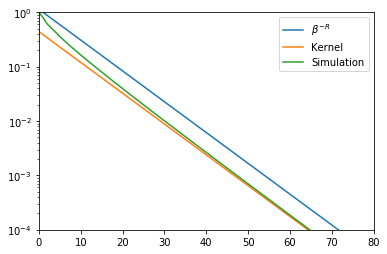

In [20]:
λA = .4
bA = 6
λB = .4
bB = 1
A = bimodal(λA, bA)
B = bimodal(λB, bB)
β, K = kernel_two_queues(A, B)
simu = make_CCDF(simu_two_queues(A, B))
description = "two_queues_λA_%s_bA_%s_λB_%s_bB_%s" % (λA, bA, λB, bB)
plot_kernel(β, K, simu, description, xm=80, ym=1e-4)